In [1]:
import cv2 as cv
import pathlib
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "dataset"
DATA_DIR = list(glob.glob(f"{DATA_DIR}/*/*.jpg"))
len(DATA_DIR)

155

In [22]:
def preprocess_image(image):
    """Reshape the image to a 2D array of pixels and 3 color values (RGB) and convert to float."""
    pixel_values = image.reshape((-1, 3))
    return np.float32(pixel_values)

def perform_kmeans_clustering(pixel_values, k=3):
    """Perform k-means clustering on the pixel values."""
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    compactness, labels, centers = cv.kmeans(pixel_values, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
    return compactness, labels, np.uint8(centers)

def create_segmented_image(pixel_values, labels, centers):
    """Create a segmented image using the cluster centroids."""
    segmented_image = centers[labels.flatten()]
    return segmented_image.reshape(image.shape)

def create_masked_image(image, labels, cluster_to_disable):
    """Create a masked image by disabling a specific cluster."""
    masked_image = np.copy(image).reshape((-1, 3))
    masked_image[labels.flatten() == cluster_to_disable] = [0, 0, 0]
    return masked_image.reshape(image.shape)

def clean_mask(image):
    kernel = np.ones((3,3), np.uint8)
    closing = cv.morphologyEx(image, cv.MORPH_CLOSE, kernel, iterations=3)
    return closing

def display_image(image):
    """Display the image using matplotlib."""
    plt.imshow(image)
    plt.axis('off')
    

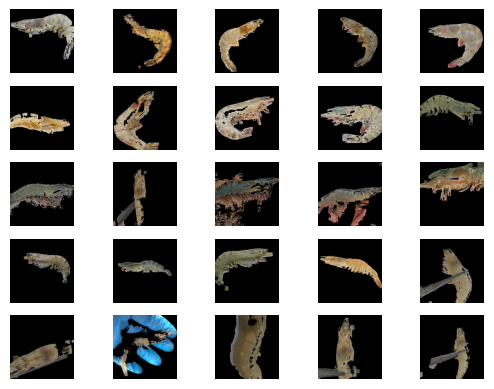

In [108]:
grid = 5
i = 0

def shrimp_segmentation(image):
    # Convert the image to the HSV color space
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)

    # Define the lower and upper threshold values for shrimp color
    lower_threshold = np.array([0, 20, 20])  # Adjust these values based on the shrimp color
    upper_threshold = np.array([20, 255, 255])  # Adjust these values based on the shrimp color

    # Create a mask based on the color threshold
    mask = cv.inRange(hsv, lower_threshold, upper_threshold)

    # Perform morphological operations to enhance the mask
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations=2)
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel, iterations=2)

    # Apply the mask to the original image
    segmented_image = cv.bitwise_and(image, image, mask=mask)

    return segmented_image

def read_image(file_path):
    """Read the image and convert it to RGB."""
    image = cv.imread(file_path)
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)


def kmeans_segmentation(image):
    # Reshape the image to a 2D array of pixels
    pixels = image.reshape(-1, 3).astype(np.float32)

    # Define the criteria and perform k-means clustering
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv.kmeans(pixels, 2, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

    # Calculate the average pixel value for each cluster
    average_colors = np.uint8(centers)

    # Find the index of the cluster with the lower average pixel value
    cluster_index = np.argmin(average_colors)

    # Convert the label image to 8-bit and reshape it to the original image shape
    labels = labels.reshape(image.shape[:2]).astype(np.uint8)

    white_area = np.sum(labels == 1)

    # Convert the label image to 8-bit and reshape it to the original image shape
    labels = labels.reshape(image.shape[:2]).astype(np.uint8)

    # Invert the segmentation mask if the white area is larger than the segmented part
    if white_area > (labels.size - white_area):
        labels = 1 - labels
        
    # Segment the image based on the labels
    segmented_image = np.where(labels == 1, 255, 0).astype(np.uint8)

    return segmented_image

def spot_cleanup(image):
    # Convert the image to grayscale
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Perform adaptive thresholding to obtain a binary image
    _, binary = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    # Perform morphological operations to clean the spots in the background
    kernel_background = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
    cleaned_background = cv.morphologyEx(binary, cv.MORPH_OPEN, kernel_background, iterations=2)

    # Perform morphological operations to close the spots in the foreground
    kernel_foreground = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))
    closed_foreground = cv.morphologyEx(cleaned_background, cv.MORPH_CLOSE, kernel_foreground, iterations=2)

    # Invert the binary image to obtain the final mask
    mask = cv.bitwise_not(closed_foreground)

    # Apply the mask to the original image
    segmented_image = cv.bitwise_and(image, image, mask=mask)

    return segmented_image

for i, path in enumerate(DATA_DIR):
    if i == grid**2: break
        
    ax = plt.subplot(grid, grid, i + 1)
    image = read_image(path)
    mask = kmeans_segmentation(image)
    masked_image = cv.bitwise_and(image, image, mask=mask)
    masked_image = spot_cleanup(masked_image)
    display_image(masked_image)
